<a href="https://colab.research.google.com/github/Vijay-Akshar/Data-Science-Projects/blob/main/AbsenteeismAtWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import io, zipfile, requests

In [2]:
!mkdir -p /content/data/uci_absenteeism
!wget -q -O /content/data/uci_absenteeism/abs.zip "https://archive.ics.uci.edu/ml/machine-learning-databases/00445/Absenteeism_at_work_AAA.zip"
!unzip -o -q /content/data/uci_absenteeism/abs.zip -d /content/data/uci_absenteeism

In [3]:
absenteeism = pd.read_csv("/content/data/uci_absenteeism/Absenteeism_at_work.csv", sep=';')

In [4]:
absenteeism.head()
absenteeism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

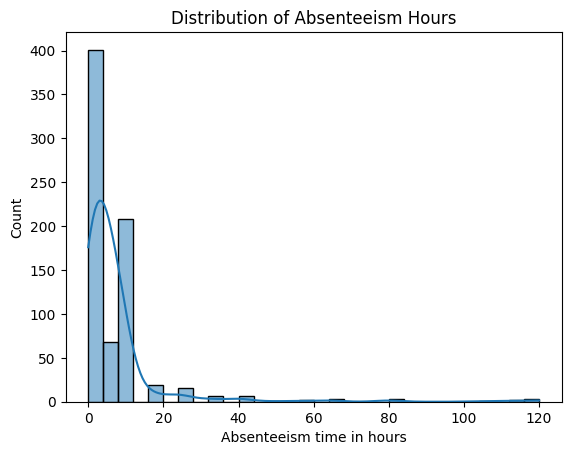

In [5]:
sns.histplot(absenteeism['Absenteeism time in hours'], bins=30, kde=True)
plt.title('Distribution of Absenteeism Hours')
plt.show()

Right Skewed

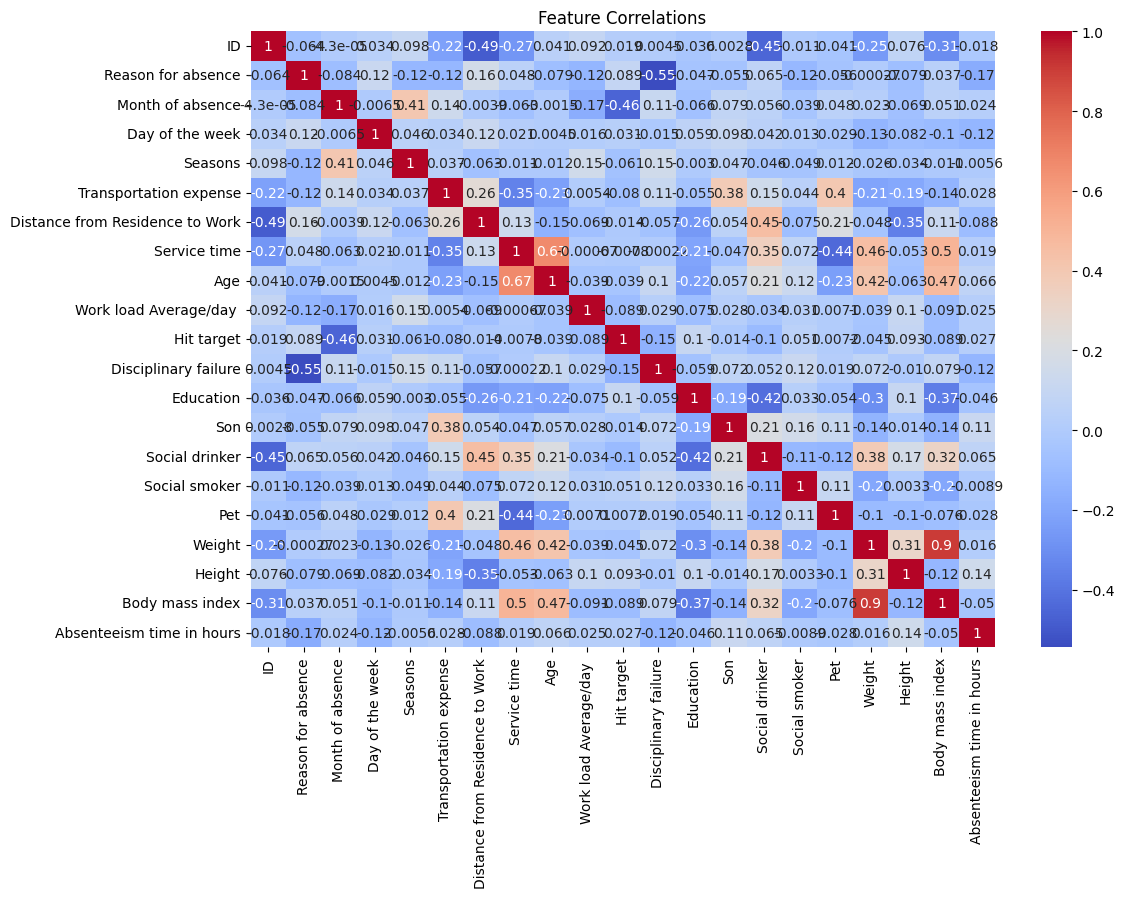

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(absenteeism.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlations")
plt.show()

In [7]:
absenteeism['HighAbsenteeism'] = absenteeism['Absenteeism time in hours'].apply(lambda x: 1 if x >= 8 else 0)
absenteeism.tail()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,HighAbsenteeism
735,11,14,7,3,1,289,36,13,33,264.604,...,1,2,1,0,1,90,172,30,8,1
736,1,11,7,3,1,235,11,14,37,264.604,...,3,1,0,0,1,88,172,29,4,0
737,4,0,0,3,1,118,14,13,40,271.219,...,1,1,1,0,8,98,170,34,0,0
738,8,0,0,4,2,231,35,14,39,271.219,...,1,2,1,0,2,100,170,35,0,0
739,35,0,0,6,3,179,45,14,53,271.219,...,1,1,0,0,1,77,175,25,0,0


In [8]:
reason_counts = absenteeism['HighAbsenteeism'].value_counts()
print(reason_counts)

HighAbsenteeism
0    469
1    271
Name: count, dtype: int64


In [9]:
categorical_cols = ['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Education']
absenteeism[categorical_cols].head()

,Reason for absence,Month of absence,Day of the week,Seasons,Education
0,26,7,3,1,1
1,0,7,3,1,1
2,23,7,4,1,1
3,7,7,5,1,1
4,23,7,5,1,1


In [10]:
absenteeism = pd.get_dummies(absenteeism, columns=categorical_cols, drop_first=True)

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Exclude target column
features = absenteeism.drop(columns=['HighAbsenteeism'])
target = absenteeism['HighAbsenteeism']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_df, target, test_size=0.2, random_state=42, stratify=target)

In [13]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Target distribution in training:", y_train.value_counts(normalize=True))

Train shape: (592, 65)
Test shape: (148, 65)
Target distribution in training: HighAbsenteeism
0    0.633446
1    0.366554
Name: proportion, dtype: float64


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
# Model architecture
model = keras.Sequential([
    layers.Dense(64, input_dim=X_train.shape[1], activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [17]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6012 - auc: 0.5186 - loss: 0.6797 - val_accuracy: 0.6216 - val_auc: 0.5968 - val_loss: 0.6511
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6482 - auc: 0.6384 - loss: 0.6410 - val_accuracy: 0.6351 - val_auc: 0.7401 - val_loss: 0.6148
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6465 - auc: 0.7040 - loss: 0.6136 - val_accuracy: 0.6757 - val_auc: 0.8318 - val_loss: 0.5759
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6898 - auc: 0.7894 - loss: 0.5708 - val_accuracy: 0.7568 - val_auc: 0.8828 - val_loss: 0.5253
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7208 - auc: 0.7968 - loss: 0.5465 - val_accuracy: 0.8176 - val_auc: 0.9087 - val_loss: 0.4740
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8086 - auc: 0.8938 - loss: 0.4676 - val_accuracy: 0.8311 - val_auc: 0.9204 - val_loss: 0.4146
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

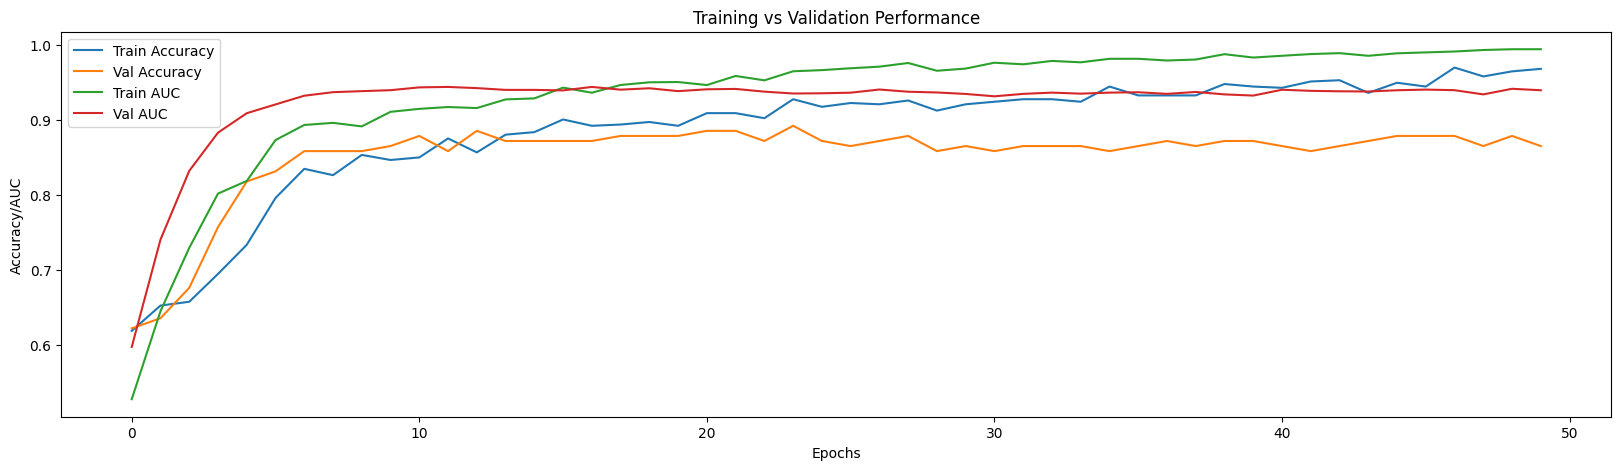

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/AUC')
plt.legend()
plt.title('Training vs Validation Performance')
plt.show()


In [19]:
loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test AUC: {auc:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8560 - auc: 0.9362 - loss: 0.3642 
Test Accuracy: 0.86
Test AUC: 0.94


In [20]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [21]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[86  8]
 [12 42]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90        94
           1       0.84      0.78      0.81        54

    accuracy                           0.86       148
   macro avg       0.86      0.85      0.85       148
weighted avg       0.86      0.86      0.86       148



In [24]:
model.save("absenteeism_model.h5")

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',  # track validation loss
    patience=5,          # stop after 5 epochs of no improvement
    restore_best_weights=True
)

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model_opt = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='sigmoid')
])

model_opt.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # reduce learning rate by half
    patience=3,  # if no improvement for 3 epochs
    verbose=1
)


In [28]:
history_opt = model_opt.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.5375 - auc: 0.5425 - loss: 0.8617 - val_accuracy: 0.6622 - val_auc: 0.7663 - val_loss: 0.6488 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6877 - auc: 0.7347 - loss: 0.6163 - val_accuracy: 0.6486 - val_auc: 0.8228 - val_loss: 0.6216 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7012 - auc: 0.7719 - loss: 0.5723 - val_accuracy: 0.6554 - val_auc: 0.8665 - val_loss: 0.5964 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7595 - auc: 0.8319 - loss: 0.4959 - val_accuracy: 0.6622 - val_auc: 0.8870 - val_loss: 0.5751 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7943 - auc: 0.8904 - loss: 0.4202 - val_accuracy: 0.6757 - val_auc: 0.8960 - val_loss: 0.5539 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8258 - auc: 0.9009

In [30]:
loss, accuracy, auc = model_opt.evaluate(X_test, y_test)
print(f"Optimized Test Accuracy: {accuracy:.2f}")
print(f"Optimized Test AUC: {auc:.2f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8492 - auc: 0.9226 - loss: 0.3980
Optimized Test Accuracy: 0.84
Optimized Test AUC: 0.93


In [31]:
model_opt.save("absenteeism_dl_optimized.h5")